<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/ae_mnist_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Autoencoder (using MLP and CNN) for fashion MNIST
# Based on 
# https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [1]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

import sklearn

import seaborn as sns;
sns.set(style="ticks", color_codes=True)

import pandas as pd
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows


In [2]:
# Tensorflow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

print("tf version {}".format(tf.__version__))
if tf.test.is_gpu_available():
    print(tf.test.gpu_device_name())
else:
    print("TF cannot find GPU")

tf version 2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/device:GPU:0


In [3]:


np.random.seed(0)

FASHION = True

if FASHION:
  (train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data() 
  class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
else:
  (train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data() 
  class_names = [str(x) for x in range(10)]
train_images = train_images / 255.0
test_images = test_images / 255.0

print(np.shape(train_images))
print(np.shape(test_images))
#(60000, 28, 28)
#(10000, 28, 28)

# Partition training into train and valid
X_train_full = train_images; y_train_full = train_labels
X_test = test_images; y_test = test_labels
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]




4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        

In [16]:
# Visualize 2d manifold from  encodings using tSNE

from sklearn.manifold import TSNE
import matplotlib

def plot_embeddings_tsne(encodings):
  np.random.seed(42)
  tsne = TSNE()
  X_valid_2D = tsne.fit_transform(encodings)
  X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

  # adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
  plt.figure(figsize=(10, 8))
  cmap = plt.cm.tab10
  plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
  image_positions = np.array([[1., 1.]])
  for index, position in enumerate(X_valid_2D):
      dist = np.sum((position - image_positions) ** 2, axis=1)
      if np.min(dist) > 0.02: # if far enough from other images
          image_positions = np.r_[image_positions, [position]]
          imagebox = matplotlib.offsetbox.AnnotationBbox(
              matplotlib.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
              position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
          plt.gca().add_artist(imagebox)
  plt.axis("off")
  plt.show()

# MLP

In [5]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3164 - val_rounded_accuracy: 0.9006
Epoch 2/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9199
Epoch 3/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2984 - val_rounded_accuracy: 0.9202
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9286
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9286
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

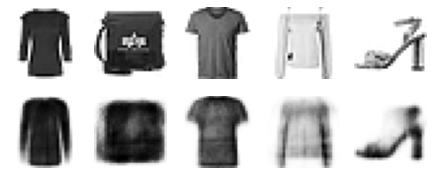

In [6]:
show_reconstructions(stacked_ae)

(5000, 30)


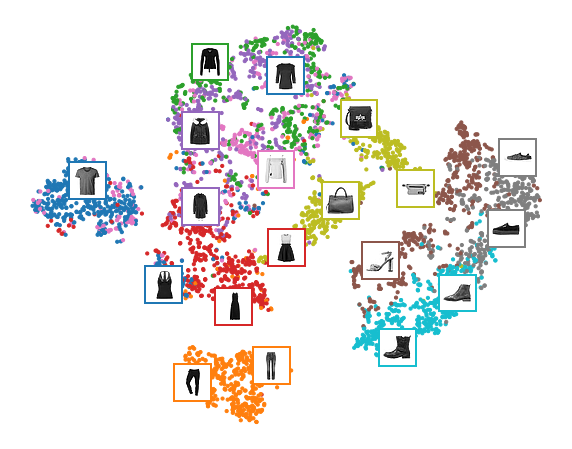

In [17]:
Z = stacked_encoder.predict(X_valid)
print(Z.shape)
plot_embeddings_tsne(Z)


# CNN

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2851 - val_rounded_accuracy: 0.9283
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2756 - rounded_accuracy: 0.9414 - val_loss: 0.2728 - val_rounded_accuracy: 0.9458
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2708 - rounded_accuracy: 0.9462 - val_loss: 0.2696 - val_rounded_accuracy: 0.9497
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2681 - rounded_accuracy: 0.9491 - val_loss: 0.2686 - val_rounded_accuracy: 0.9491
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2664 - rounded_accuracy: 0.9510 - val_loss: 0.2670 - val_rounded_accuracy: 0.9511


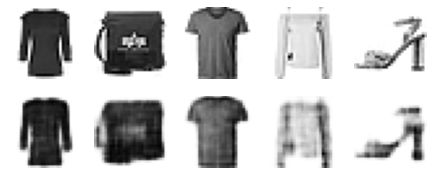

In [11]:


show_reconstructions(conv_ae)


(5000, 3, 3, 64)
(5000, 576)


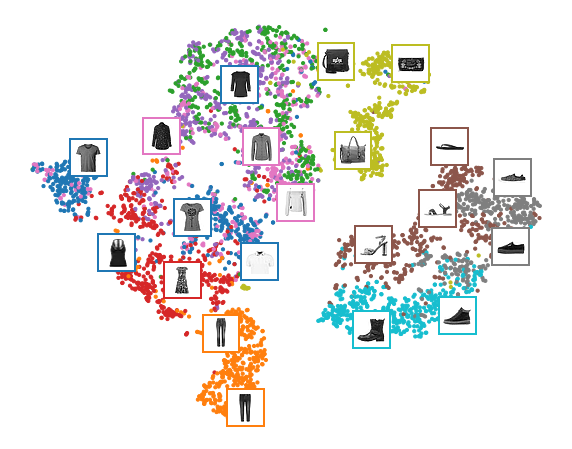

In [18]:
Z = conv_encoder.predict(X_valid)
print(Z.shape)
N = Z.shape[0]
ZZ = np.reshape(Z, (N,-1))
print(ZZ.shape)

plot_embeddings_tsne(ZZ)